# PA005: High Value Customer Identification (Insiders)

## 0.0 Planejamento da solução (IOT)

### Input - Entrada

1. Problema de Negócio
    - Selecionar os clientes mais valiosos para integrar um programa de fidelização

2. Conjunto de dados
    - Vendas de um e-commerce durante o perído de um ano.

### Output - Saída

1. A indicação das pessoas que farão parte do programa de Insiders
    - Lista: client_id | is_insider
                2930   |   yes/1
                3492   |   no/1

2. Relatório com as respostas das perguntas de negócio
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?
                

### Task - Tarefas

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegível? O que são clientes de maior "valor"?
    - Faturamento:
        - Alto Ticket médio. (média dos gastos na empresa)
        - Alto LTV. (Total gasto na empresa)
        - Baixa Recência. (intervalo entre as compras)
        - Alto basket size. (itens comprados de 1 vez) - Talvez seja redundante em relação às outras métricas
        - Baixa probabilidade de Churn. (chance de deixar de consumir produtos da empresa) -  Comum rodar um modelo de churn e           usar o resultado como coluna na clusterização
        - Alta previsão de LTV.
        - Alta propensão de compra.
        
    - Custo:
        - Baixa taxa de devolução.
        
    - Experiência:
        - Média alta das avaliações.
        
    
2. Quantos clientes farão parte do grupo?
    - Número total de clientes
    - % do grupo Insiders
    

3. Quais as principais características desses clientes?
    - Escrever características do cliente: 
        - Idade
        - Localização
        
    - Escrever características do consumo.
        - Atributos da clusterização. 
        

4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders?
    - Faturamento total do ano
    - Faturamento do grupo Insiders
    

5. Qual a expectativa de faturamento desse grupo para os próximos meses? (Ex: Assumir essa métrica no planejamento do orçamento da empresa)
    - LTV do grupo Insiders
    - Análise de Cohort. (Marcação em relação a algo e acompanhamento do desempenho)
    

6. Quais as condições para uma pessoa ser elegível ao Insiders?
    - Definir a periodicidade. (1 mês, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa do grupo.

7. Quais as condições para uma pessoa ser removida do Insiders?
    - Definir a periodicidade. (1 mês, 3 meses)
    - A pessoa precisa ser desimilar ou não-parecido com uma pessoa do grupo.


8. Qual a garantia que o programa Insiders é melhor que o restante da base?
    - Teste A/B.
    - Teste A/B Bayesiano.
    - Teste de hipóteses.
     

9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de compra
    - Frete
    - Visita a empresa




## Benchmark de soluções
### 1. Desk Research

# 0.0 Imports

In [2]:
import inflection
import numpy   as np
import pandas  as pd
import seaborn as sns
import umap.umap_ as umap

from matplotlib import pyplot as plt
from IPython.display import HTML

from sklearn import cluster as c
from sklearn import metrics as m

from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1 Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Load dataset

In [4]:
#load data
df = pd.read_csv('data/Ecommerce.csv', encoding='unicode_escape')

#drop extra column
df = df.drop(columns=['Unnamed: 8'], axis=1)

In [5]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

# 1.0 Descrição dos dados

In [6]:
df1 = df.copy()

## 1.1 Rename Columns

In [7]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
            'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [8]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 541909
Number of Columns: 8


## 1.3 Data Types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [10]:
# invoice_no são números. Como está dando object, deve haver algum caractere em algum lugar
# Usar o código abaixo para descobrir onde está;
df1['invoice_no'] = df1['invoice_no'].astype(int)

ValueError: invalid literal for int() with base 10: 'C536379'

## 1.4 Check NA

In [10]:
df1.isnull().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [11]:
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.2f}'.format(1 - (df1.shape[0] / df.shape[0])))

Removed data: 0.25


## 1.6 Change Dtypes

In [12]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [13]:
#invoice_no e stock_code serão analisados posteriormente

#invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

#customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

In [14]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int32
country                 object
dtype: object

## 1.7 Descriptive Statistics

# 2.0 Feature Engeneering

In [15]:
df2 = df1.copy()

## 2.1 Feature Creation

In [16]:
# data reference
df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
                   'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [17]:
#Gross Revenue (Faturamento) quantity * price
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

#Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

#Recency - Last day purchase - Como o dataset é antigo, usar como date o último invoice_date
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index() # Agrupa por usuários e pega a data máxima da última compra de cada
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

#Frequency
df_frequency = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index() 
df_frequency = df_frequency.rename(columns={'invoice_no': 'frequency'}) 
df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')

#AVG Ticket
df_avg_ticket = df2[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left') #Sempre calcular os NA's depois do left join

In [18]:
df_ref.head()

,customer_id,gross_revenue,recency_days,frequency,avg_ticket
0,17850,5288.63,302,35,16.950737
1,13047,3079.10,31,18,15.709694
2,12583,7187.34,2,18,28.634821
3,13748,948.25,95,5,33.866071
4,15100,635.10,330,6,105.850000


# 3.0 Filtragem de Variáveis

# 4.0 EDA (Exploratory Data Analysis)

# 5.0 Data Preparation

# 6.0 Feature Selection

# 7.0 Hyperparameter Fine-Tunning

In [20]:
df7 = df_ref.drop(columns=['customer_id'])

In [21]:
df7.head()

,gross_revenue,recency_days,frequency,avg_ticket
0,5288.63,302,35,16.950737
1,3079.10,31,18,15.709694
2,7187.34,2,18,28.634821
3,948.25,95,5,33.866071
4,635.10,330,6,105.850000


In [22]:
clusters = [2,3,4,5,6,7]

## 7.1 Within-Cluster Sum of Square (WSS)

In [ ]:
wss = []
for k in clusters:
    #model definition
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    
    #model training
    kmeans.fit(df7)
    
    #validation
    wss.append(kmeans.inertia_)
    
# plot wss - Elbow Method - Pegar o ponto onde houver maior variação, quebra (3 ou 5) Isso significa que após esses pontos a variação de distancia dentro dos clusteres n está diminuindo muito, então n é o ideal
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum of Square');
plt.title('WSS vs K');

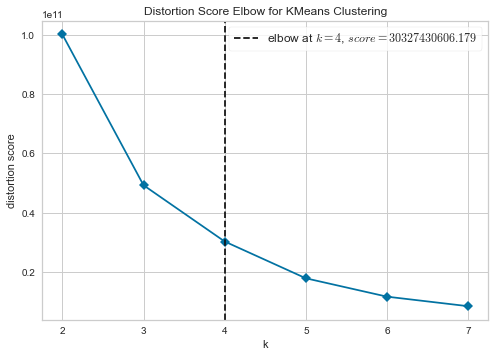

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [34]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(df7)
kmeans.show()

## 7.2 Sillhouette Score (SS)

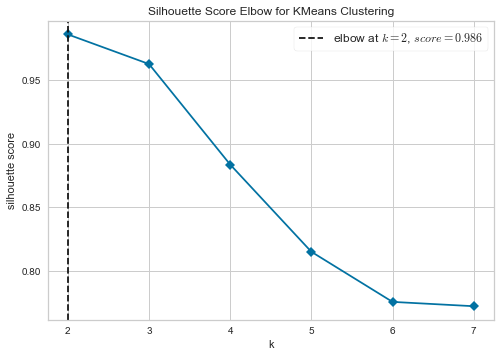

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [35]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(df7)
kmeans.show()

## 7.3 Silhouette Analysis

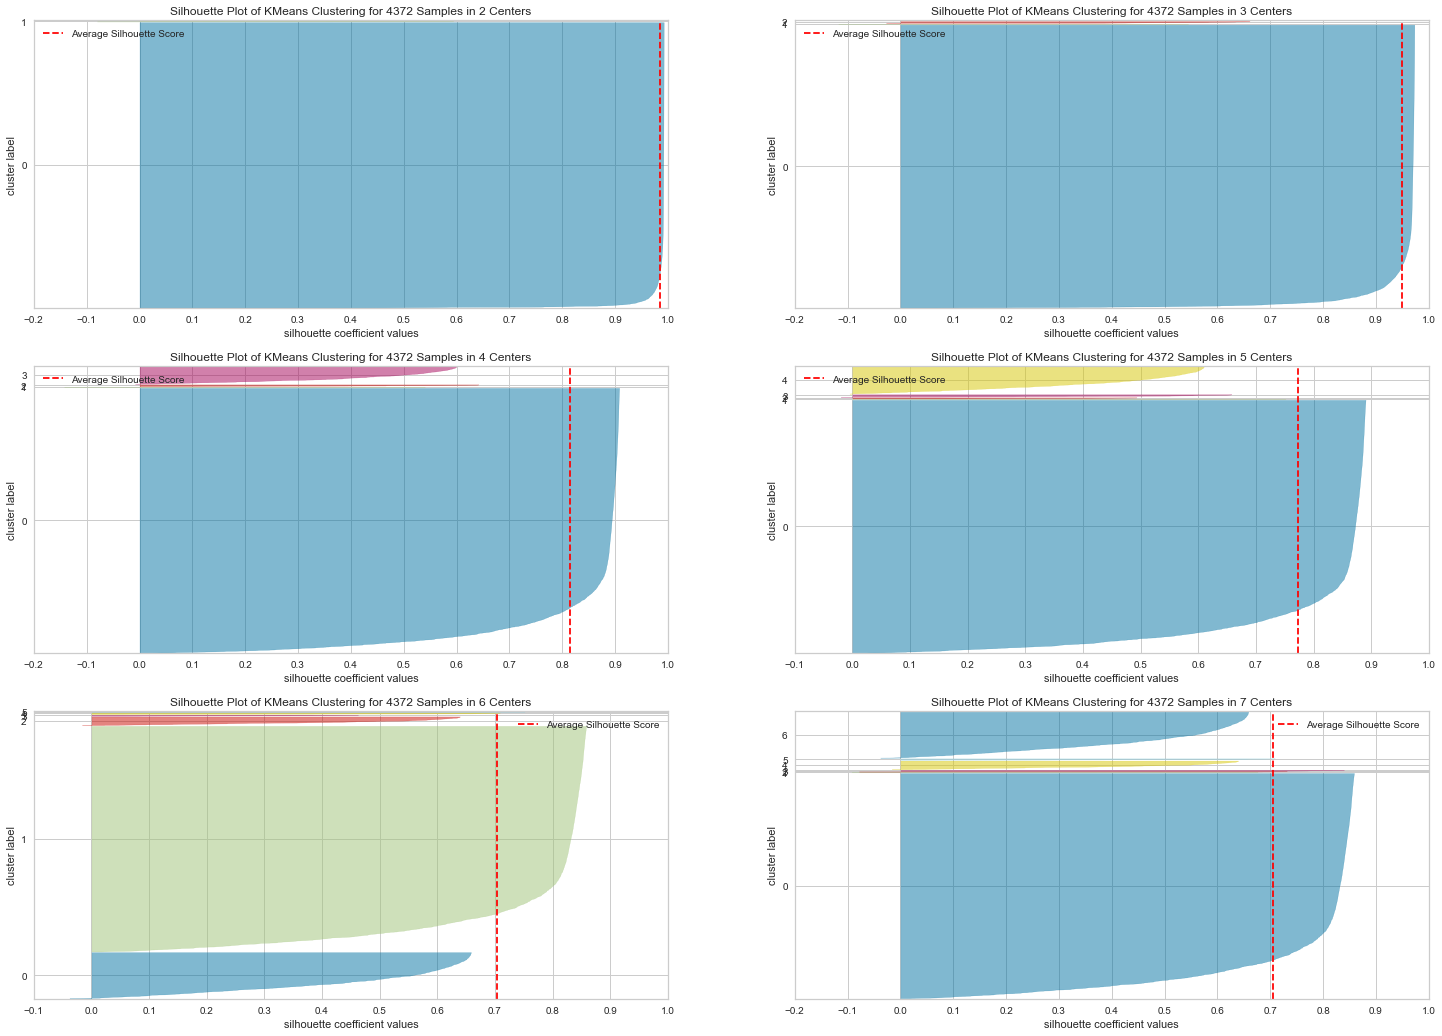

In [39]:
fig, ax = plt.subplots(3, 2, figsize=(25, 18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2) #Para poder plotar os gráficos. O valor é de acordo com o k mínimo
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df7)
    visualizer.finalize()

In [43]:
df7.head()

,gross_revenue,recency_days,frequency,avg_ticket
0,5288.63,302,35,16.950737
1,3079.10,31,18,15.709694
2,7187.34,2,18,28.634821
3,948.25,95,5,33.866071
4,635.10,330,6,105.850000


# 8.0 Model Training

## 8.1 K-Means

In [21]:
#model definition
k=4
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

#model training
kmeans.fit(df7)

#clustering
labels = kmeans.labels_


### 8.2 Cluster Validation

In [22]:
#WSS
print('WSS value: {}'.format(kmeans.inertia_))

#SS
print(m.silhouette_score(df7, labels, metric='euclidean'))

WSS value: 40056506734.60243
0.8139972028952444


# 9.0 Cluster Analysis

In [23]:
df9 = df_ref.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,frequency,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,3
1,13047,3079.10,31,18,15.709694,0
2,12583,7187.34,2,18,28.634821,3
3,13748,948.25,95,5,33.866071,0
4,15100,635.10,330,6,105.850000,0


## 9.1 Visualization Inspection

C:\Users\Ed\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


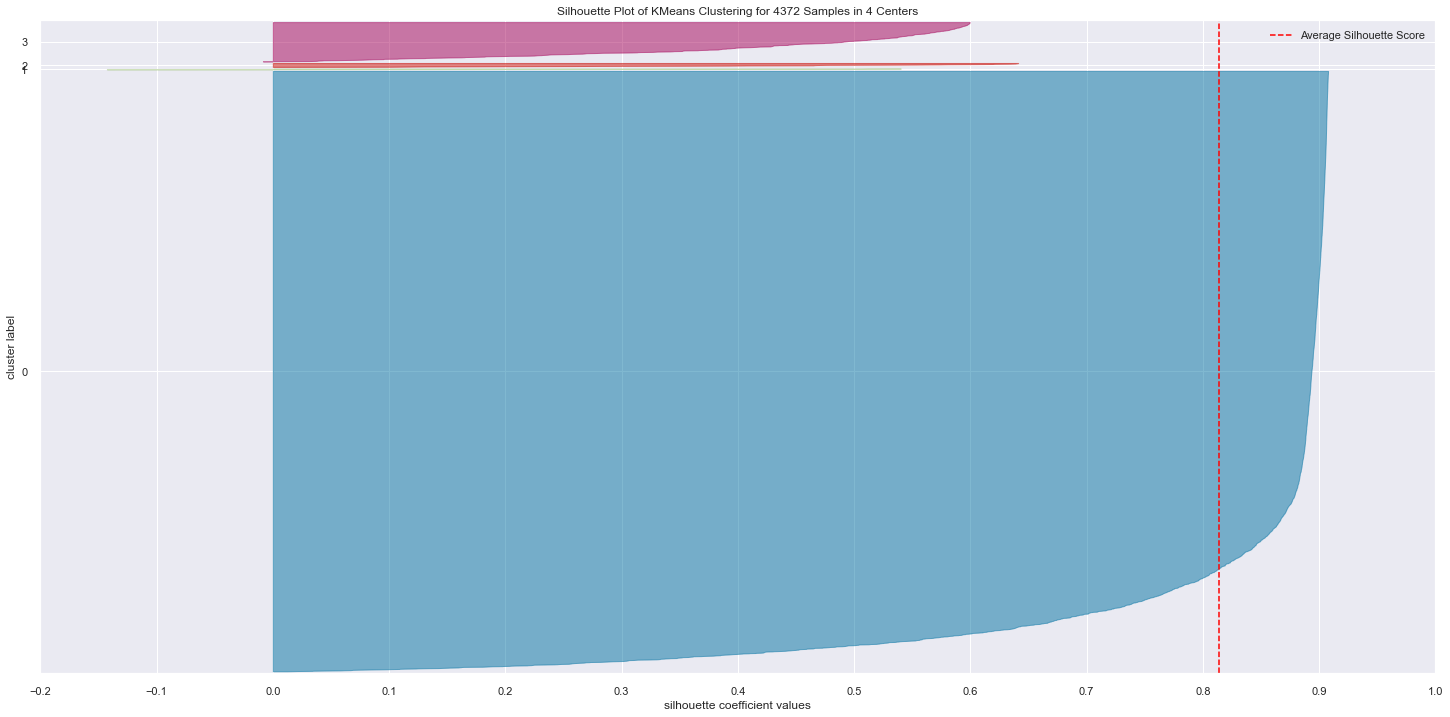

In [27]:
#fig = px.scatter_3d(df9, x='recency_days', y='frequency', z='gross_revenue', color='cluster')
#fig.show()

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(df7)
visualizer.finalize()

## 9.3 2d plot

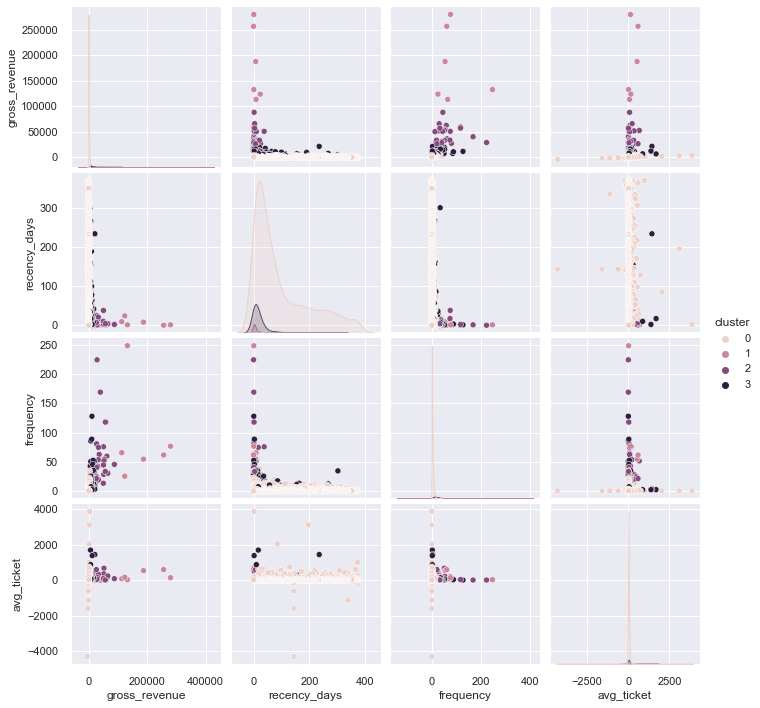

In [28]:
df_viz = df9.drop(columns='customer_id', axis = 1)
sns.pairplot(df_viz, hue='cluster')

## 9.3 UMAP - t-SNE

#PCA - Matrix, Espaço de Distância - Espaço Hilbert - 9 condições - Colorários
#UMAP, t-SNE - Manifold - Topologia - Ferramentas que fazem a projeção de alta dimensão para baixa dimensão.




<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

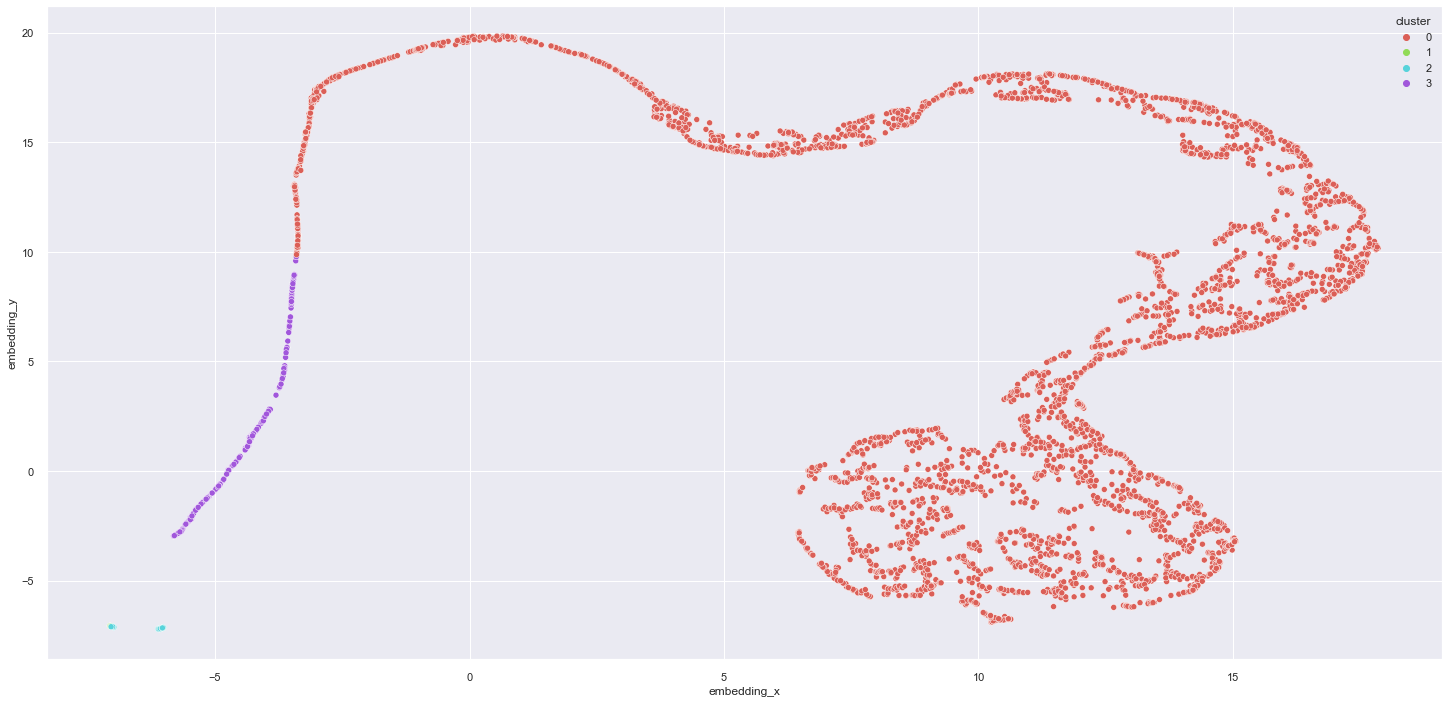

In [31]:
reducer = umap.UMAP(random_state=42) #UMAP é melhor para muitos dados pq executa mais rápido. t-SNE é mais robusto, tem melhor resultado, mas demora.
embedding = reducer.fit_transform(df7)

#embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',
                hue='cluster',
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz)

#Os pontos próximos devem ter a mesma cor
#Encontra a similaridade entre os vizinhos e faz a projeção num espaço menor

In [32]:
df9.head()

,customer_id,gross_revenue,recency_days,frequency,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,3
1,13047,3079.10,31,18,15.709694,0
2,12583,7187.34,2,18,28.634821,3
3,13748,948.25,95,5,33.866071,0
4,15100,635.10,330,6,105.850000,0


## 9.4 Cluster Profile

In [36]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

#AVG Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

#AVG Recency
df_avg_recency = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, how='inner', on='cluster')

#AVG Frequency
df_avg_frequency = df9[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, how='inner', on='cluster')

#AVG_Ticket
df_avg_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, how='inner', on='cluster')


In [37]:
df_cluster.head()

,cluster,customer_id,perc_customer,gross_revenue,recency_days,frequency,avg_ticket
0,0,4071,93.115279,946.696250,96.969295,3.641120,25.359654
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,28,0.640439,42614.387143,6.178571,57.821429,162.862605
3,3,267,6.107045,8089.028652,20.280899,19.528090,62.783157


### Cluster 01: (Candidato à Insider)
    - Número de customers: 6 (0.2% dos customers)
    - Recência em média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: $182.182,00 dólares
        
### Cluster 02: 
    - Número de customers: 31 (0.8% dos customers)
    - Recência em média: 14 dias
    - Compras em média:53 compras
    - Receita em média: $40.543,52 dólares
        
### Cluster 03: 
    - Número de customers: 4.335 (99% dos customers)
    - Recência em média: 92 dias
    - Compras em média:5 compras
    - Receita em média: $1.372,57 dólares

# 10.0 Deploy To Production